# Calculation of the heat transfer coefficient of air

The heat transfer coefficient is an equivalen thermal conductivity that takes into account sensible and latent heat flux at the land surface. Using a heat transfer coefficient means that heat transport at the surface can be modeled using a standard diffusion equation, without explicitely modeling the sesnible and latent heat fluxes. This is important for accurate models of surface temperatures, for instance around thermal springs

In [1]:
import numpy as np
import matplotlib.pyplot as pl

first lets define some of the parameters that are needed:

In [19]:
# density of air
rho = 1.29
# heat capacity
c = 1000.0
# measurement height for aerodynamic resistance 
dz = 1.8  

# aerodynamic resistance, see Liu et al (2007), Hydrology and Earth System Sciences 11 (2)
ras = [25, 75, 125]

# air temperature
Ta = 10.0

# surface temperature
Ts = np.arange(Ta + 1, 101, 1.0)

# specific latent heat of vaporisation
L = 2.264e6

# air pressure
Pa = 1.0e5

# relative humdity
RH_air = 1.0



next calculate the sensible heat flux (H), the latent heat flux (LE) and the heat transfer coefficients for sensible and latent heat flux (Ks and Kl). The equations are based on Bateni and Entekhabi (2012) WRR 48 (4).

In [20]:
def Magnus_eq(T):
    
    P = 0.61094 * np.exp(17.625 * T / (T + 243.04))
        
    return P * 1000.0


def calculate_heat_transfer_coeff_sensible_hf(rho, c, ra, dz):
    """
    
    """
    
    Ksi = rho * c / ra * dz
        
    return Ksi


def calculate_heat_transfer_coeff_latent_hf(Ts, Ta, Pa, RH_air, rho, L, dz, ra):
    """
    
    """
    
    esa = Magnus_eq(Ta)
    qa_sat = 0.622 * esa / Pa
    qa = qa_sat * RH_air

    ess = Magnus_eq(Ts)
    qs = 0.622 * ess / Pa
    
    Kl = rho * L * dz / ra * (qs - qa) / (Ts - Ta)

    return Kl


Kss = []
Kls = []
Kts = []

for ra in ras:

    H = rho * c / ra * (Ts - Ta)

    #print('calculated sensible heat flux = %0.2f W m-2' % H)

    #Ksi = rho * c / ra * dz
    Ksi = calculate_heat_transfer_coeff_sensible_hf(rho, c, ra, dz)
    Ks = np.ones_like(Ts) * Ksi
    #print('calculated conductivity for sensible heat flux: %0.2f W m-1 K-1' % Ks)

    # calculate saturated specific humidity surface and air
    esa = Magnus_eq(Ta)
    qa_sat = 0.622 * esa / Pa
    qa = qa_sat * RH_air

    ess = Magnus_eq(Ts)
    qs = 0.622 * ess / Pa

    LE = rho * L / ra * (qs - qa)

    #print('calculated potential latent heat flux = %0.2f W m-2' % LE)

    #Kl = rho * L * dz / ra * (qs - qa) / (Ts - Ta)
    Kl = calculate_heat_transfer_coeff_latent_hf(Ts, Ta, Pa, RH_air, rho, L, dz, ra)
    
    #print('calculated conductivity for latent heat flux: %0.2f W m-1 K-1' % Kl)

    #K = (H + LE) * dz / (Ts - Ta)
    K = Ks + Kl
    
    Kss.append(Ks)
    Kls.append(Kl)
    Kts.append(K)

and finally make a figure of the heat transfer coefficient and how it depends on temperature:

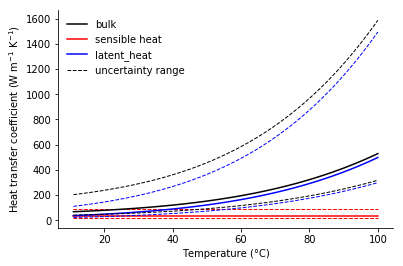

In [21]:
fig, ax = pl.subplots(1, 1)

#ax.fill_between(Ts, Kts[0], Kts[-1], color='gray', hatch='//')
#ax.fill_between(Ts, Kss[0], Kss[-1], color='red', alpha=0.5)
#ax.fill_between(Ts, Kls[0], Kls[1], color='blue', alpha=0.5)
leg_unc, = ax.plot(Ts, Kts[0], color='black', lw=1.0, ls='--')
ax.plot(Ts, Kss[0] , color='red', lw=1.0, ls='--')
ax.plot(Ts, Kls[0] , color='blue', lw=1.0, ls='--')

leg_best, = ax.plot(Ts, Kts[1], color='black', lw=1.5)
leg_sens, =ax.plot(Ts, Kss[1] , color='red', lw=1.5, ls='-')
leg_lat, = ax.plot(Ts, Kls[1] , color='blue', lw=1.5, ls='-')

ax.plot(Ts, Kts[2], color='black', lw=1.0, ls='--')
ax.plot(Ts, Kss[2] , color='red', lw=1.0, ls='--')
ax.plot(Ts, Kls[2] , color='blue', lw=1.0, ls='--')

degree_symbol = chr(176)
ax.set_xlabel('Temperature (%sC)' % degree_symbol)
ax.set_ylabel(r'Heat transfer coefficient (W m$^{-1}$ K$^{-1}$)')

legs = [leg_best, leg_sens, leg_lat, leg_unc]
labels = ['bulk', 'sensible heat', 'latent_heat', 'uncertainty range']

ax.legend(legs, labels, frameon=False, loc='upper left')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig('fig/heat_transfer_coefficient.pdf')


In [5]:
print('Surface temperature and heat transfer coefficient (K):')
for T, Kmin, Kbest, Kmax in zip(Ts, Kts[0], Kts[1], Kts[-1]):
    print('T=%0.0f\tK=%0.0f (%0.0f-%0.0f)' % (T, Kbest, Kmin, Kmax))

Surface temperature and heat transfer coefficient (K):
T=11	K=64 (102-46)
T=12	K=65 (103-47)
T=13	K=66 (105-48)
T=14	K=67 (107-49)
T=15	K=68 (109-49)
T=16	K=69 (111-50)
T=17	K=70 (113-51)
T=18	K=72 (115-52)
T=19	K=73 (117-53)
T=20	K=74 (119-54)
T=21	K=76 (121-55)
T=22	K=77 (123-56)
T=23	K=79 (126-57)
T=24	K=80 (128-58)
T=25	K=82 (131-59)
T=26	K=83 (133-61)
T=27	K=85 (136-62)
T=28	K=87 (139-63)
T=29	K=89 (142-64)
T=30	K=91 (145-66)
T=31	K=92 (148-67)
T=32	K=94 (151-69)
T=33	K=97 (154-70)
T=34	K=99 (158-72)
T=35	K=101 (161-73)
T=36	K=103 (165-75)
T=37	K=105 (169-77)
T=38	K=108 (172-78)
T=39	K=110 (176-80)
T=40	K=113 (180-82)
T=41	K=115 (185-84)
T=42	K=118 (189-86)
T=43	K=121 (193-88)
T=44	K=124 (198-90)
T=45	K=127 (203-92)
T=46	K=130 (208-94)
T=47	K=133 (213-97)
T=48	K=136 (218-99)
T=49	K=139 (223-101)
T=50	K=143 (228-104)
T=51	K=146 (234-106)
T=52	K=150 (240-109)
T=53	K=154 (246-112)
T=54	K=157 (252-115)
T=55	K=161 (258-117)
T=56	K=165 (265-120)
T=57	K=170 (271-123)
T=58	K=174 (278-126)

New equation for aerodynamic resitance:

Daamen & Simmonds (1996) WRR cite Choudhurry & Monteith (1988):

$$ra = \dfrac{\left( ln \dfrac{z_u - d}{z_0} \right)^2}{k_v^2 u} (1 + \delta)^{\epsilon}$$

where $z_u$ is height (m), d is the zero plane of dispalcement, which is 0 for bare soil (m), $z_0$ is the surface roughness which is 0.01 (m), k is the von Karmann constant, which equals 0.41 and u is wind speeds (m s-1).

$$\delta = 5g (z_u - d) \dfrac{T_s - T_a}{T_a \; u^2}$$

and $\epsilon$ equals for -2 when $\delta$ is less than 0 and -0.75 when $\delta$ is greater than 0


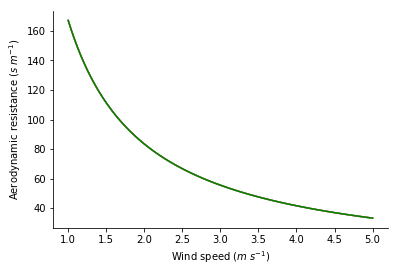

In [23]:
def calculate_ra(zu, d, z0, kv, u, Ts, Ta, g=9.81):
    
    delta = 5 * g * (zu - d) * (Ts - Ta) / (Ta * u**2)
    
    if type(delta) == float:
        if delta < 0:
            epsilon = -2.
        else:
            epsilon = -0.75
    elif type(delta) == np.ndarray:
        epsilon = np.zeros_like(delta)
        epsilon[delta<0] == -2.
        epsilon[delta>=0] == -0.75
        
    ra = np.log((zu-d)/z0)**2 / (kv**2 * u) * (1+delta)**epsilon
    
    return ra

# reference height
zu = 2.0
# surface roughness
z0 = 0.01
# von Karman's constant
kv = 0.41
# zero plane displacement
d = 0.0
#
Ta = 10.0
# 
#Ts = np.linspace(0, 100, 101)
Tss = [0.0, 50.0, 100.0]

# avg wind speed, approx. 2 m/s for Bormio, 4 m/s for Beowawe
#u = 4.0
u = np.linspace(1.0, 5.0, 101)

ras = [calculate_ra(zu, d, z0, kv, u, Ts, Ta) for Ts in Tss]

fig, ax = pl.subplots(1, 1)
#ax.plot(Ts, ras, color='black')

colors = ['blue', 'orange', 'green', 'gray']

for ra, color in zip(ras, colors):
    ax.plot(u, ra, color=color)

#ax.set_xlabel('Surface temperature (degr. C)')
ax.set_xlabel(r'Wind speed ($m\;s^{-1}$)')
ax.set_ylabel(r'Aerodynamic resistance ($s\;m^{-1}$)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig('fig/aerodynamic_resistance.pdf')